In [72]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from goatools.obo_parser import GODag
from collections import Counter
import pandas as pd
from os import listdir
from os.path import isfile, isdir
from os import mkdir
import seaborn as sns
go_dag = GODag("../data/goatools_data/go-basic.obo")

../data/goatools_data/go-basic.obo: fmt(1.2) rel(2024-10-27) 44,017 Terms


In [42]:
from Bio import Entrez, SeqIO

# Set your email (required by NCBI)
Entrez.email = "lukas.becker@hhu.de"  

def get_protein_info_batch(protein_ids):
    """Fetch protein names/descriptions for multiple protein IDs."""
    try:
        # Convert list of IDs to a comma-separated string
        ids_str = ",".join(protein_ids)
        
        # Fetch records in GenBank format
        handle = Entrez.efetch(db="protein", id=ids_str, rettype="gb", retmode="text")
        records = SeqIO.parse(handle, "gb")  # Parse multiple records
        protein_info = {record.id: record.description for record in records}
        handle.close()
        
        # Extract protein descriptions
        
        
        return protein_info

    except Exception as e:
        return f"Error: {e}"

# Example usage
protein_ids = ["NP_000257", "NP_000240", "NP_001295952"]  # Replace with your IDs
proteins = get_protein_info_batch(protein_ids)

In [43]:
table = pd.read_table("../data/transcriptomics_data/pannzer/GCF_002163715/GO.out")
table = table[table["ARGOT_PPV"] >= 0.6]
table["GO_ID"] = table.goid.apply(lambda x :  "GO:"+str(x).zfill(7))
len(table.GO_ID.unique())

3359

In [44]:
table.head()

,qpid,ontology,goid,desc,ARGOT_score,ARGOT_PPV,ARGOT_rank,goclasscount,GO_ID
0,ALENMEJF_00001,BP,160,phosphorelay signal transduction system,5.231430,0.636806,1,2,GO:0000160
1,ALENMEJF_00001,BP,35556,intracellular signal transduction,4.697755,0.619411,2,2,GO:0035556
11,ALENMEJF_00002,MF,9678,diphosphate hydrolysis-driven proton transmemb...,12.144822,0.810714,1,100,GO:0009678
12,ALENMEJF_00002,BP,1902600,proton transmembrane transport,4.766659,0.621711,1,100,GO:1902600
14,ALENMEJF_00002,MF,4427,inorganic diphosphate phosphatase activity,10.799034,0.781855,2,100,GO:0004427


In [45]:
def get_go_counts_for_text(search_strings_annot:list,search_strings_go:list,path_to_annotation_file:str,path_to_go_file:str,filtering_go=True)->tuple:
    try:
        annot_table = pd.read_table(path_to_annotation_file)
        go_table = pd.read_table(path_to_go_file)
        
        go_table = go_table[go_table["ARGOT_PPV"] >= 0.6]
        go_table["GO_ID"] = go_table.goid.apply(lambda x :  "GO:"+str(x).zfill(7))
        
        filtered_df = annot_table.copy()
        print("[+] Length of the dataframe: {}".format(len(filtered_df["qpid"].unique())))
        for search_string in search_strings_annot:
            print("[+] Filtering dataframe with string: {}".format(search_string))
            filtered_df = filtered_df[filtered_df["desc"].str.contains(search_string)]
            print("\t[+] New length: {}".format(len(filtered_df["qpid"].unique())))
        
        print("[+] Extracting GO identifier ...")
        protein_list = list(filtered_df["qpid"].unique())
        filtered_go_table = go_table[go_table["qpid"].isin(protein_list)]
        print("[+] New length is: {}".format(len(filtered_go_table["qpid"].unique())))
        
        counts = {}
        if filtering_go == True:
            print("[+] Filtering go table with search strings ...")
            filtered_go_table_df = filtered_go_table.copy()
            print("[+] Length of the dataframe: {}".format(len(filtered_df["qpid"].unique())))
            for search_string in search_strings_go:
                print("\t[+] Filtering dataframe with string: {}".format(search_string))
                filtered_go_table_df = filtered_go_table_df[filtered_go_table_df["desc"].str.contains(search_string)]
                print("\t\t[+] New length: {}".format(len(filtered_go_table_df["qpid"].unique())))
        
            for go_id in filtered_go_table_df.GO_ID.unique():
                counts[go_id] = len(filtered_go_table_df[filtered_go_table_df.GO_ID == go_id])
                
        else:
            for go_id in filtered_go_table.GO_ID.unique():
                counts[go_id] = len(filtered_go_table[filtered_go_table.GO_ID == go_id])
            filtered_go_table_df = filtered_go_table.copy()
            
        compressed_counts = {}
        for protein in filtered_go_table_df["qpid"].unique():
            subset = filtered_go_table_df[filtered_go_table_df["qpid"] == protein]
            minimal_argot_count = min(subset.ARGOT_rank)
            subset = subset[subset.ARGOT_rank == minimal_argot_count]
            
            min_children = 0
            best_go = ""
            for go_id in subset.GO_ID:
                try:
                    if min_children == 0:
                        min_children = len(go_dag[go_id].children)
                        best_go = go_id
                    if len(go_dag[go_id].children) < min_children:
                        min_children = len(go_dag[go_id].children)
                        best_go = go_id
                except:
                    continue
            
            if best_go in list(compressed_counts.keys()):
                compressed_counts[best_go][0] += 1
                compressed_counts[best_go][1].append(protein)
            else:
                compressed_counts[best_go] = [1,[protein]]
            
        return counts, compressed_counts, filtered_go_table_df
    except Exception as e:
        raise Exception("[-] ERROR with exception: {}".format(e))

In [46]:
path_annot = "../data/transcriptomics_data/pannzer/GCF_002163715/anno.out"
path_go = "../data/transcriptomics_data/pannzer/GCF_002163715/GO.out"
counts, compressed_counts, table = get_go_counts_for_text(["ABC", "transport"], ["transport"], path_annot, path_go, filtering_go=True)

[+] Length of the dataframe: 4061
[+] Filtering dataframe with string: ABC
	[+] New length: 319
[+] Filtering dataframe with string: transport
	[+] New length: 314
[+] Extracting GO identifier ...
[+] New length is: 212
[+] Filtering go table with search strings ...
[+] Length of the dataframe: 314
	[+] Filtering dataframe with string: transport
		[+] New length: 138


In [47]:
compressed_counts["GO:0043190"][0]  = compressed_counts["GO:0043190"][0] + compressed_counts["GO:0140359"][0] + compressed_counts["GO:0055052"][0]
compressed_counts["GO:0043190"][1]  = compressed_counts["GO:0043190"][1] + compressed_counts["GO:0140359"][1] + compressed_counts["GO:0055052"][1]

# amino acid
compressed_counts["GO:0006865"][0]  = compressed_counts["GO:0006865"][0] + compressed_counts["GO:0015424"][0] 
compressed_counts["GO:0006865"][1]  = compressed_counts["GO:0006865"][1] + compressed_counts["GO:0015424"][1]

compressed_counts["GO:0006865"][0] = compressed_counts["GO:0006865"][0] + compressed_counts["GO:0015192"][0] + compressed_counts["GO:0015190"][0] + compressed_counts["GO:1903785"][0]
compressed_counts["GO:0006865"][1] = compressed_counts["GO:0006865"][1] + compressed_counts["GO:0015192"][1] + compressed_counts["GO:0015190"][1] + compressed_counts["GO:1903785"][1]

# polyamine
compressed_counts["GO:0015417"][0] = compressed_counts["GO:0015417"][0] + compressed_counts["GO:0015846"][0]
compressed_counts["GO:0015417"][1] = compressed_counts["GO:0015417"][1] + compressed_counts["GO:0015846"][1]

# molybdate 
compressed_counts["GO:0015098"][0] = compressed_counts["GO:0015098"][0] + compressed_counts["GO:0015689"][0]
compressed_counts["GO:0015098"][1] = compressed_counts["GO:0015098"][1] + compressed_counts["GO:0015689"][1]

# peptide
compressed_counts["GO:0015833"][0] = compressed_counts["GO:0015833"][0] + compressed_counts["GO:0035442"][0] + compressed_counts["GO:1904680"][0] + compressed_counts["GO:0035672"][0]
compressed_counts["GO:0015833"][1] = compressed_counts["GO:0015833"][1] + compressed_counts["GO:0035442"][1] + compressed_counts["GO:1904680"][1] + compressed_counts["GO:0035672"][1]

# carbohydrate
compressed_counts["GO:0008643"][0] = compressed_counts["GO:0008643"][0] + compressed_counts["GO:0015752"][0] + compressed_counts["GO:0015753"][0] + compressed_counts["GO:0015762"][0] + compressed_counts["GO:1904981"][0]
compressed_counts["GO:0008643"][1] = compressed_counts["GO:0008643"][1] + compressed_counts["GO:0015752"][1] + compressed_counts["GO:0015753"][1] + compressed_counts["GO:0015762"][1] + compressed_counts["GO:1904981"][1]

# organic acid
compressed_counts["GO:0015849"][0] = compressed_counts["GO:0015849"][0] + compressed_counts["GO:0015740"][0]
compressed_counts["GO:0015849"][1] = compressed_counts["GO:0015849"][1] + compressed_counts["GO:0015740"][1]

# NEW Groups
# inorganic anion transport 
compressed_counts["GO:0015698"] =[0,[]]
compressed_counts["GO:0015698"][0] = compressed_counts["GO:0015706"][0] + compressed_counts["GO:1902358"][0] + compressed_counts["GO:0015716"][0] + compressed_counts["GO:0015098"][0] + compressed_counts["GO:0035435"][0] + compressed_counts["GO:0015689"][0]
compressed_counts["GO:0015698"][1] = compressed_counts["GO:0015706"][1] + compressed_counts["GO:1902358"][1] + compressed_counts["GO:0015716"][1] + compressed_counts["GO:0015098"][1] + compressed_counts["GO:0035435"][1] + compressed_counts["GO:0015689"][1]

# metal ion
compressed_counts["GO:0030001"] =[0,[]]
compressed_counts["GO:0030001"][0] = compressed_counts["GO:0030001"][0] + compressed_counts["GO:1901678"][0] + compressed_counts["GO:0034755"][0]
compressed_counts["GO:0030001"][1] = compressed_counts["GO:0030001"][1] + compressed_counts["GO:1901678"][1] + compressed_counts["GO:0034755"][1]


#vitamine
compressed_counts["GO:0051180"] =[0,[]]
compressed_counts["GO:0051180"][0] = compressed_counts["GO:0015889"][0] + compressed_counts["GO:0015888"][0]
compressed_counts["GO:0051180"][1] = compressed_counts["GO:0015889"][1] + compressed_counts["GO:0015888"][1]


# macromolecule and lipid
compressed_counts["GO:0033036"] =[0,[]]
compressed_counts["GO:0033036"][0] = compressed_counts["GO:0042953"][0] + compressed_counts["GO:0034040"][0] + compressed_counts["GO:0015914"][0] + compressed_counts["GO:0046836"][0]
compressed_counts["GO:0033036"][1] = compressed_counts["GO:0042953"][1] + compressed_counts["GO:0034040"][1] + compressed_counts["GO:0015914"][1] + compressed_counts["GO:0046836"][1]

# nitrogen compound
compressed_counts["GO:0071705"] =[0,[]]
compressed_counts["GO:0071705"][0] = compressed_counts["GO:0042884"][0] + compressed_counts["GO:0031460"][0]
compressed_counts["GO:0071705"][1] = compressed_counts["GO:0042884"][1] + compressed_counts["GO:0031460"][1]


del compressed_counts["GO:0140359"]
del compressed_counts["GO:0015424"]
del compressed_counts["GO:0055052"]
del compressed_counts["GO:0015192"]
del compressed_counts["GO:0015190"]
del compressed_counts["GO:1903785"]
del compressed_counts["GO:0015846"]
del compressed_counts["GO:0015689"]
# peptide 
del compressed_counts["GO:0035442"]
del compressed_counts["GO:1904680"]
del compressed_counts["GO:0035672"]
# carbohydrate
del compressed_counts["GO:0015752"]
del compressed_counts["GO:0015753"]
del compressed_counts["GO:0015762"]
del compressed_counts["GO:1904981"]
# organic acid
del compressed_counts["GO:0015740"]
# inorganic anion
del compressed_counts["GO:0015706"]
del compressed_counts["GO:1902358"]
del compressed_counts["GO:0015716"]
del compressed_counts["GO:0015098"]
del compressed_counts["GO:0035435"]

# metal ion
del compressed_counts["GO:1901678"]
del compressed_counts["GO:0034755"]

# vitamin
del compressed_counts["GO:0015888"]
del compressed_counts["GO:0015889"]

# macromolecule lipid
del compressed_counts["GO:0042953"] 
del compressed_counts["GO:0034040"]
del compressed_counts["GO:0015914"]
del compressed_counts["GO:0046836"]

# nitrogen compound
del compressed_counts["GO:0042884"]
del compressed_counts["GO:0031460"]

In [48]:
table["gene_id"] = table.qpid.apply(lambda x: "AEP_"+x.split("_")[-1])

In [49]:
#enriched_counts = {}
#for go_id in counts.keys():
#    if counts[go_id] >= 10:
#        enriched_counts[go_id] = counts[go_id]

In [50]:
amino_acid_transporter = table[table["GO_ID"] == "GO:0006865"]
amino_acid_transporter = amino_acid_transporter.rename(columns={"gene_id":"old_locus_tag"})
len(table[table["GO_ID"] == "GO:0006865"].qpid.unique())

28

In [51]:
table

,qpid,ontology,goid,desc,ARGOT_score,ARGOT_PPV,ARGOT_rank,goclasscount,GO_ID,gene_id
5883,ALENMEJF_00267,MF,15424,ABC-type amino acid transporter activity,10.193572,0.768285,1,95,GO:0015424,AEP_00267
5884,ALENMEJF_00267,BP,3333,amino acid transmembrane transport,7.708389,0.707833,1,95,GO:0003333,AEP_00267
5886,ALENMEJF_00267,MF,15171,amino acid transmembrane transporter activity,8.080618,0.717452,2,95,GO:0015171,AEP_00267
5887,ALENMEJF_00267,BP,6865,amino acid transport,6.703818,0.680648,2,95,GO:0006865,AEP_00267
5889,ALENMEJF_00267,MF,140359,ABC-type transporter activity,6.687995,0.680204,3,95,GO:0140359,AEP_00267
...,...,...,...,...,...,...,...,...,...,...
80621,ALENMEJF_04071,BP,6820,monoatomic anion transport,6.406309,0.672211,6,77,GO:0006820,AEP_04071
80622,ALENMEJF_04071,MF,42626,ATPase-coupled transmembrane transporter activity,4.799229,0.622792,6,77,GO:0042626,AEP_04071
80624,ALENMEJF_04071,BP,98660,inorganic ion transmembrane transport,4.141476,0.600191,7,97,GO:0098660,AEP_04071
80625,ALENMEJF_04071,MF,15318,inorganic molecular entity transmembrane trans...,4.485778,0.612229,8,97,GO:0015318,AEP_04071


In [52]:
deseq_table = pd.read_csv("../data/transcriptomics_data/hydra_vs_liquid_mouth_opening_paper.csv",sep=";")
deseq_table.padj = deseq_table.padj.apply(lambda x: float(x.replace(",",".")))
deseq_table.log2FoldChange = deseq_table.log2FoldChange.apply(lambda x: float(x.replace(",",".")))
#deseq_table = deseq_table[deseq_table.padj <= 0.05]
deseq_table.head()

,locus_tag,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Length_bp,old_locus_tag
0,AEP_RS02615,"287,5034493",9.006442,"0,30104772","29,91698968","1,18E-196",2.380000e-193,435,AEP_00519
1,AEP_RS17950,"1284,479523",7.684159,"0,348353731","22,05849607","7,92E-108",2.450000e-105,1335,AEP_03593
2,AEP_RS09325,"425,6966443",7.430103,"0,38969423","19,06649408","4,79E-81",6.420000e-79,801,AEP_01870
3,AEP_RS06845,"345,1951382",6.997285,"0,375447772","18,6371725","1,61E-77",1.950000e-75,1155,AEP_01369
4,AEP_RS06820,"98,76114326",6.709044,"0,297051896","22,58542591","6,03E-113",2.200000e-110,1092,AEP_01364


In [53]:
#deseq_table = pd.read_csv("../data/transcriptomics_data/hydra_vs_liquid.csv",sep=",")
#deseq_table = deseq_table.rename(columns={"Unnamed: 0":"locus_tag"})
#deseq_table.head()

In [54]:
#deseq_table = pd.read_csv("../data/transcriptomics_data/hydra_mono_culture_kiel_vs_liquid_mono_culture_kiel_just_mono.csv")
#deseq_table = deseq_table[deseq_table.padj <= 0.05]
#deseq_table["Unnamed: 0"] = deseq_table["Unnamed: 0"].apply(lambda x: x.split(":")[-1])
#deseq_table = deseq_table.rename(columns={"Unnamed: 0":"old_locus_tag"})
#deseq_table.head()

In [55]:
translation_table = pd.read_table("../data/transcriptomics_data/translation_table_corrected.csv", sep="\t")
deseq_table = translation_table.merge(deseq_table, on="old_locus_tag")
#deseq_table = translation_table.merge(deseq_table, on = "locus_tag")

In [56]:
deseq_table

,protein_id,old_locus_tag,locus_tag_x,locus_tag_y,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Length_bp
0,WP_087493495.1,AEP_00001,AEP_RS00005,AEP_RS00005,"110,9558022",-2.253533,"0,270492304","-8,331228853","8,00E-17",7.270000e-16,321
1,WP_087493496.1,AEP_00002,AEP_RS00010,AEP_RS00010,"70,73024799",1.006805,"0,258383505","3,896551696","9,76E-05",2.496820e-04,2052
2,WP_087493497.1,AEP_00003,AEP_RS00015,AEP_RS00015,"199,1580292",-1.442751,"0,289182382","-4,989068517","6,07E-07",2.090000e-06,528
3,WP_087493498.1,AEP_00004,AEP_RS00020,AEP_RS00020,"23,55564952",1.135699,"0,327885383","3,463707335","0,000532786",1.212662e-03,792
4,WP_087493499.1,AEP_00005,AEP_RS00025,AEP_RS00025,"54,79810876",-1.087678,"0,37583733","-2,894012267","0,003803533",7.320798e-03,519
...,...,...,...,...,...,...,...,...,...,...,...
3872,WP_232460042.1,AEP_04111,AEP_RS20530,AEP_RS20530,"707,6206961",0.463425,"0,155131373","2,987304503","0,002814492",5.547465e-03,1056
3873,WP_087497472.1,AEP_04112,AEP_RS20535,AEP_RS20535,"33,69010414",-0.892348,"0,369804253","-2,413027461","0,015820628",2.706426e-02,204
3874,WP_087497473.1,AEP_04113,AEP_RS20540,AEP_RS20540,"106,6481938",-1.464817,"0,312697154","-4,684458069","2,81E-06",8.900000e-06,309
3875,WP_087497474.1,AEP_04114,AEP_RS20545,AEP_RS20545,"260,6328885",-0.922437,"0,206310426","-4,471113473","7,78E-06",2.320000e-05,573


In [57]:
def calculate_figsize(n, base_height=0.4, min_height=4, max_height=15, width_per_char=0.15, base_width=8):
    """
    Dynamically calculates an optimal figure size based on the number of bars.

    Parameters:
    - n: Number of bars (len of dataframe)
    - base_height: Height per bar (default 0.4 inches per bar)
    - min_height: Minimum figure height (default 4 inches)
    - max_height: Maximum figure height (default 15 inches)
    - width_per_char: Width adjustment per character of longest label
    - base_width: Base width for visualization (adjusted by label length)

    Returns:
    - (width, height) tuple for `figsize`
    """
    # Calculate height based on the number of bars
    height = min(max(n * base_height, min_height), max_height)

    # Estimate the longest label length in characters (simulating labels)
    max_label_length = np.random.randint(5, 20)  # Simulating label length
    width = base_width + max_label_length * width_per_char

    return (width, height)

GO:0043190	level-04	depth-05	ATP-binding cassette (ABC) transporter complex [cellular_component]
37


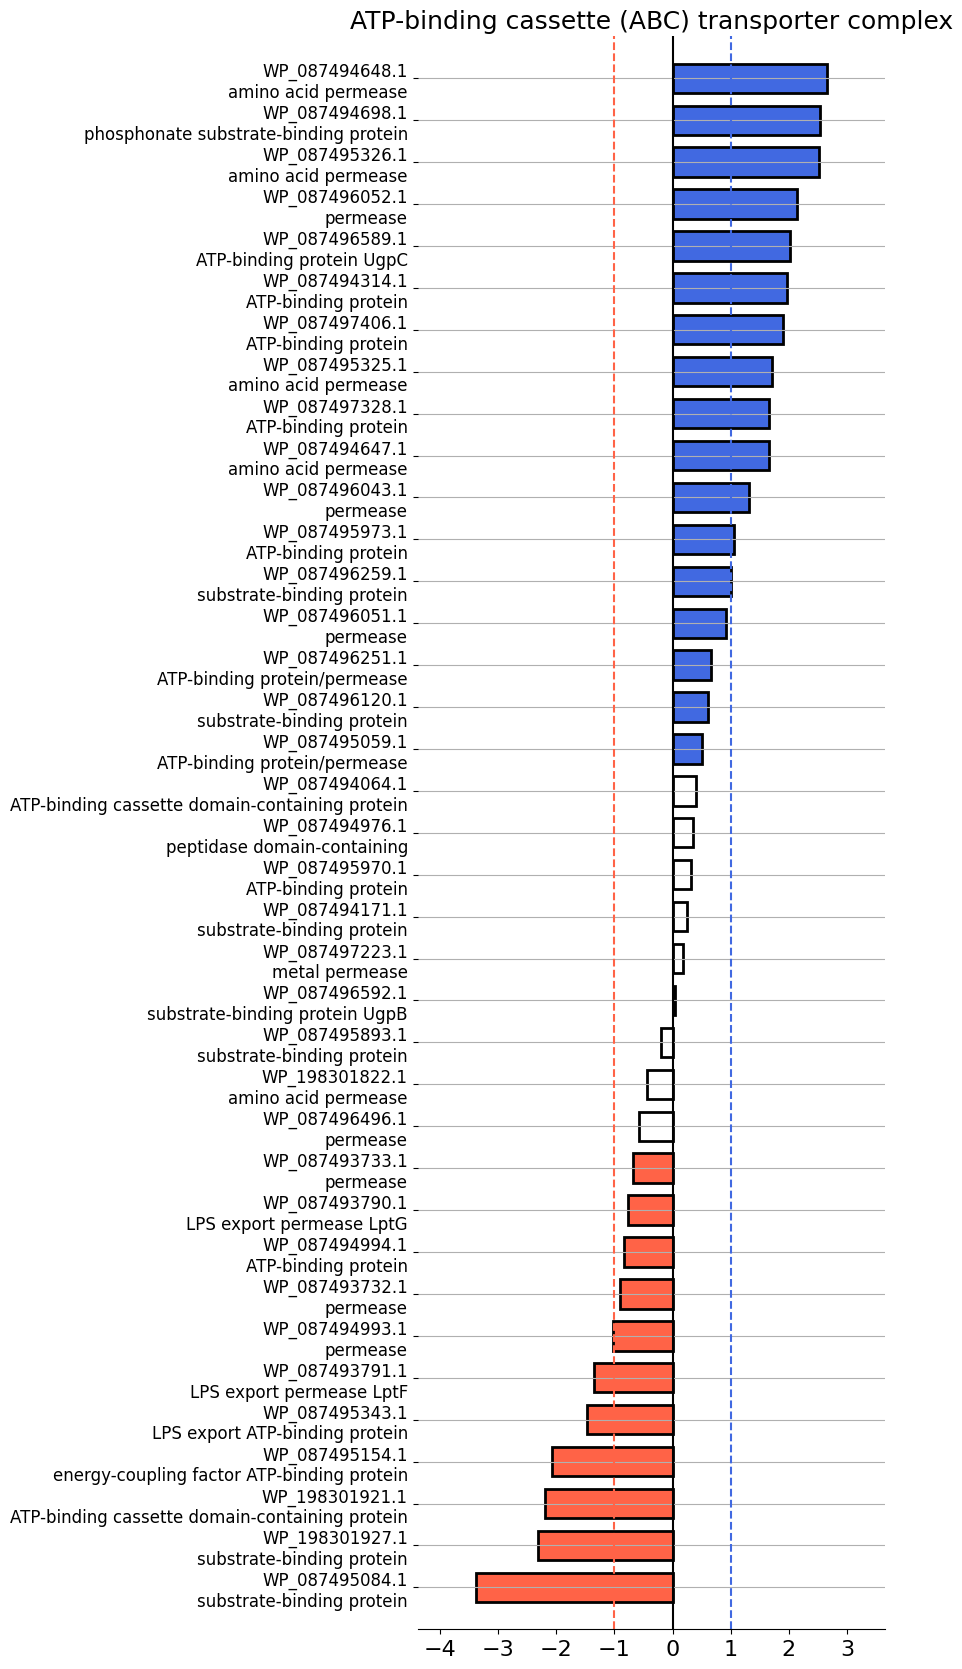

GO:0015833	level-06	depth-06	peptide transport [biological_process]
12


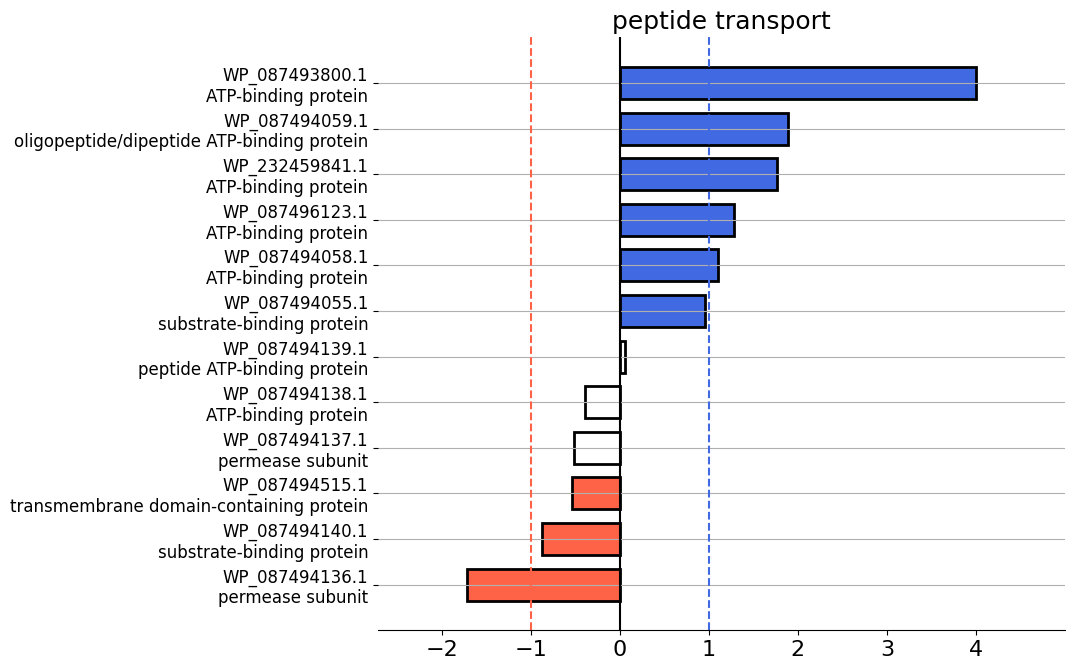

GO:0015417	level-04	depth-07	ABC-type polyamine transporter activity [molecular_function]
3


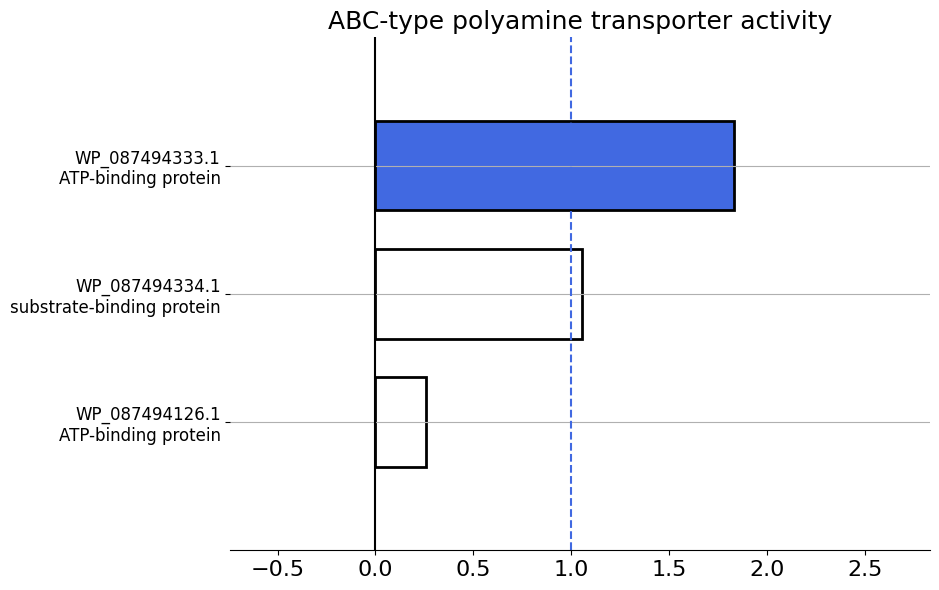

GO:0006865	level-04	depth-04	amino acid transport [biological_process]
23


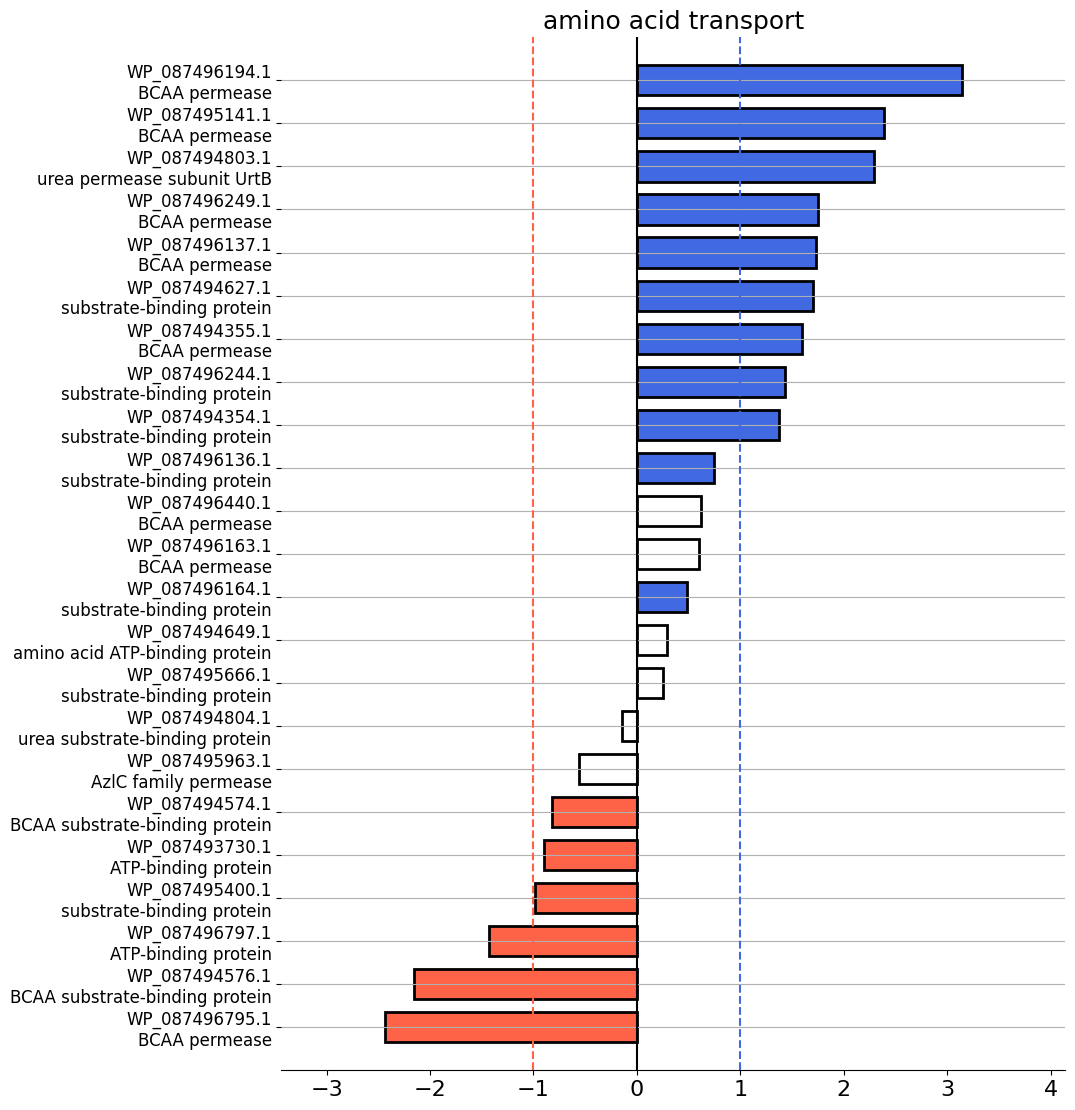

GO:0015803	level-05	depth-06	branched-chain amino acid transport [biological_process]
14


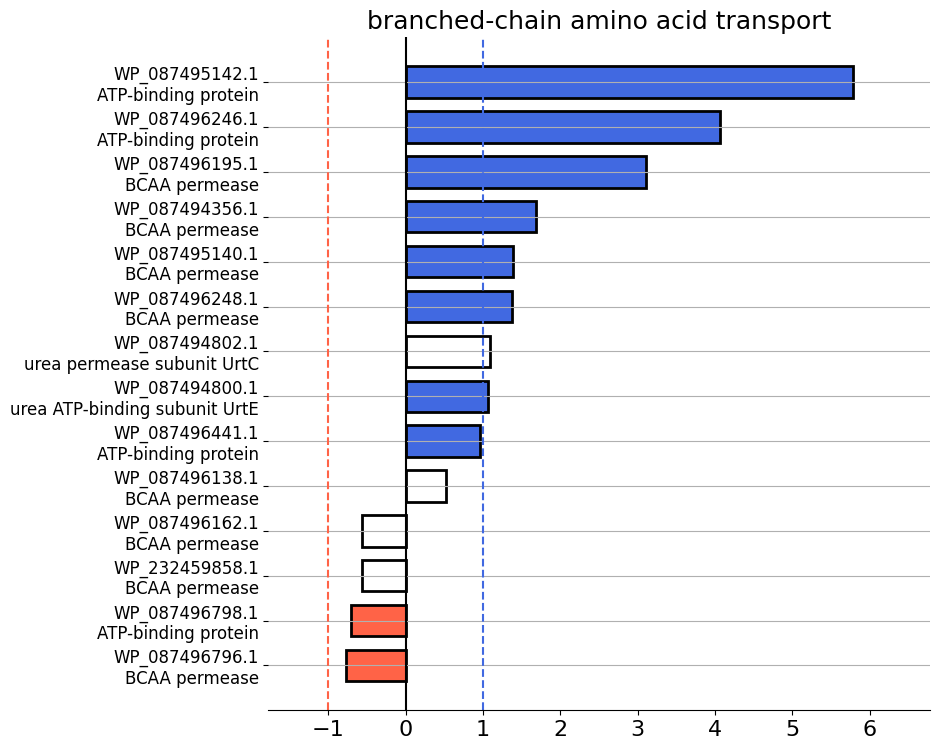

GO:0030001	level-06	depth-06	metal ion transport [biological_process]
4


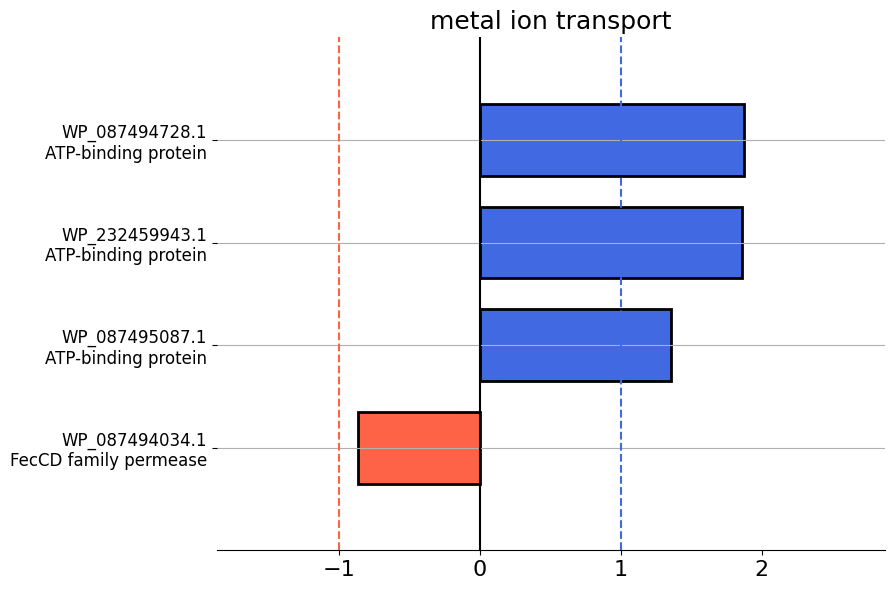

GO:0008643	level-04	depth-04	carbohydrate transport [biological_process]
9


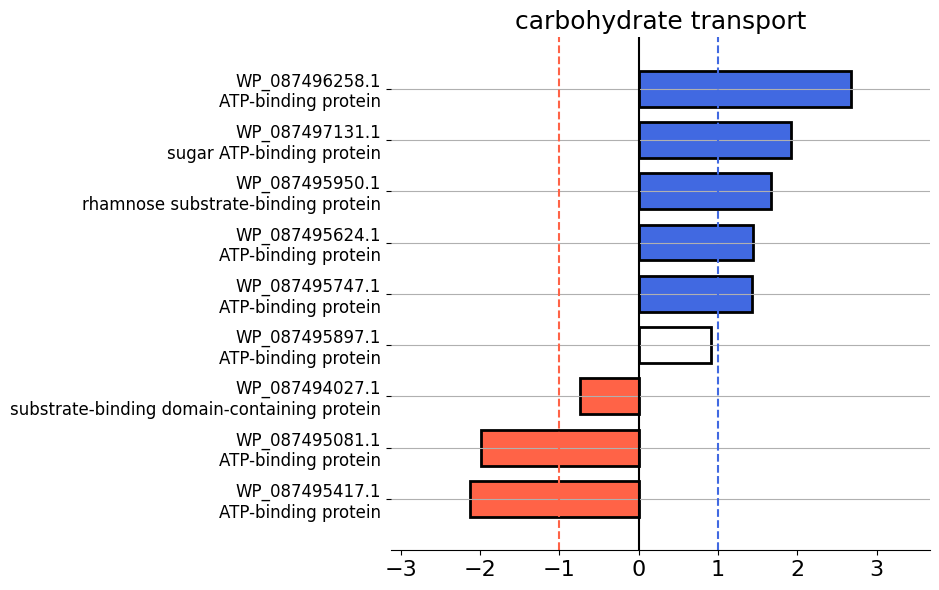

GO:0022803	level-03	depth-03	passive transmembrane transporter activity [molecular_function]
2


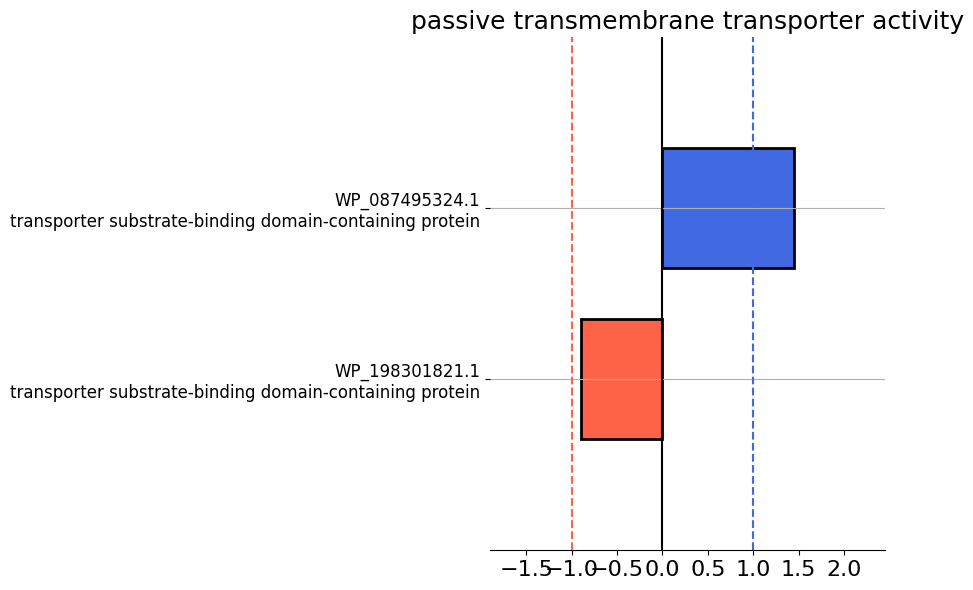

GO:0015849	level-04	depth-04	organic acid transport [biological_process]
2


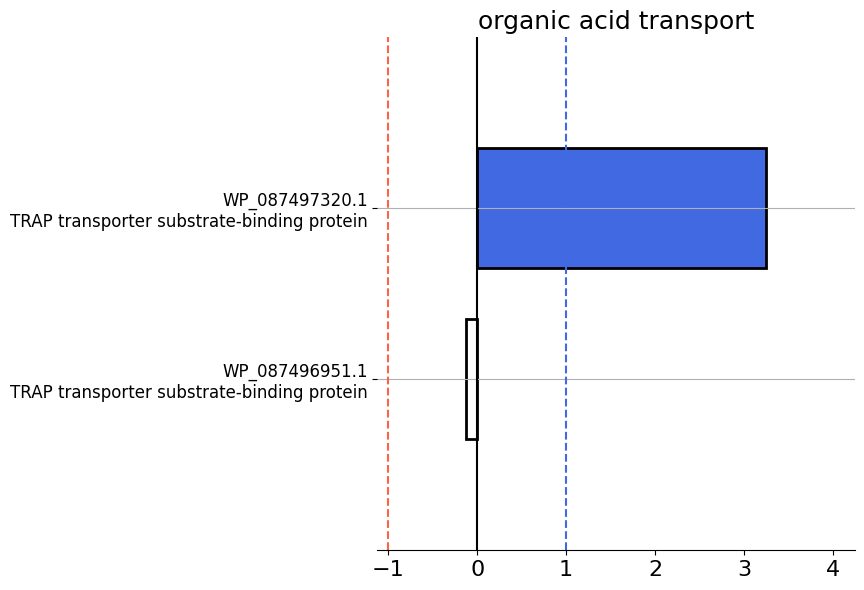

GO:0006833	level-05	depth-05	water transport [biological_process]
1
GO:0015698	level-04	depth-04	inorganic anion transport [biological_process]
12


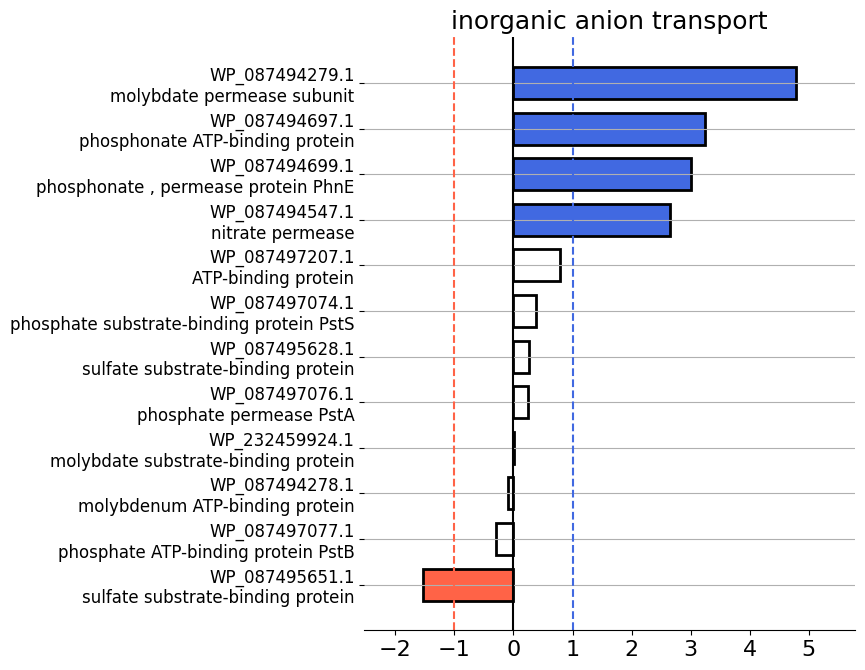

GO:0051180	level-04	depth-04	vitamin transport [biological_process]
5


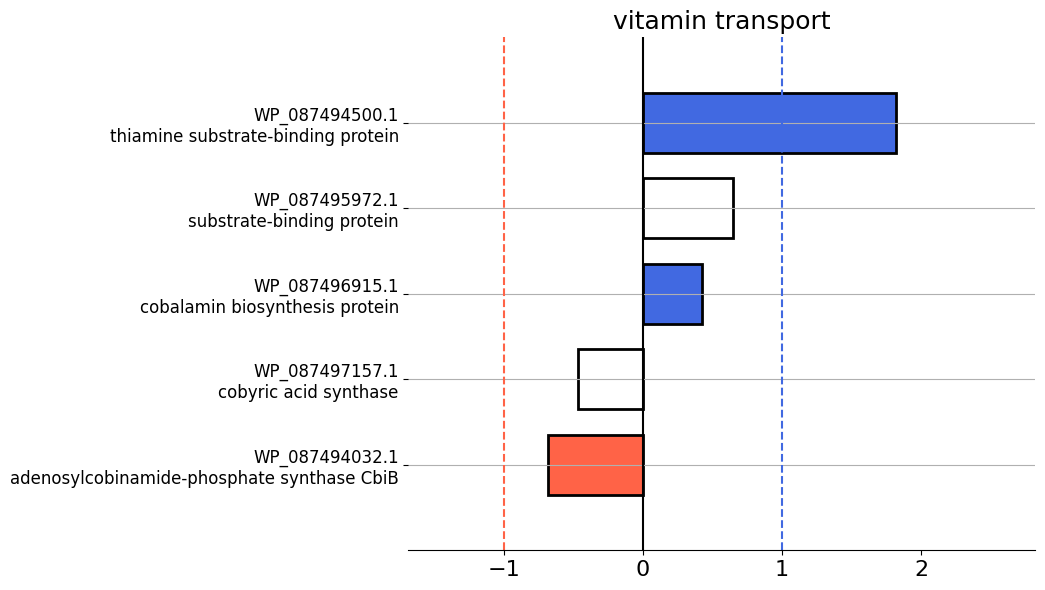

GO:0033036	level-02	depth-02	macromolecule localization [biological_process]
9


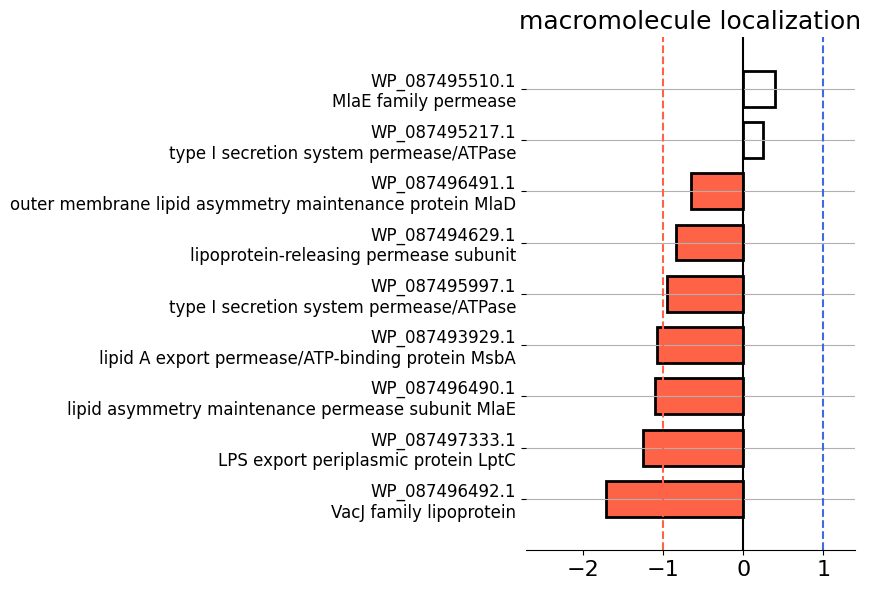

GO:0071705	level-04	depth-04	nitrogen compound transport [biological_process]
4


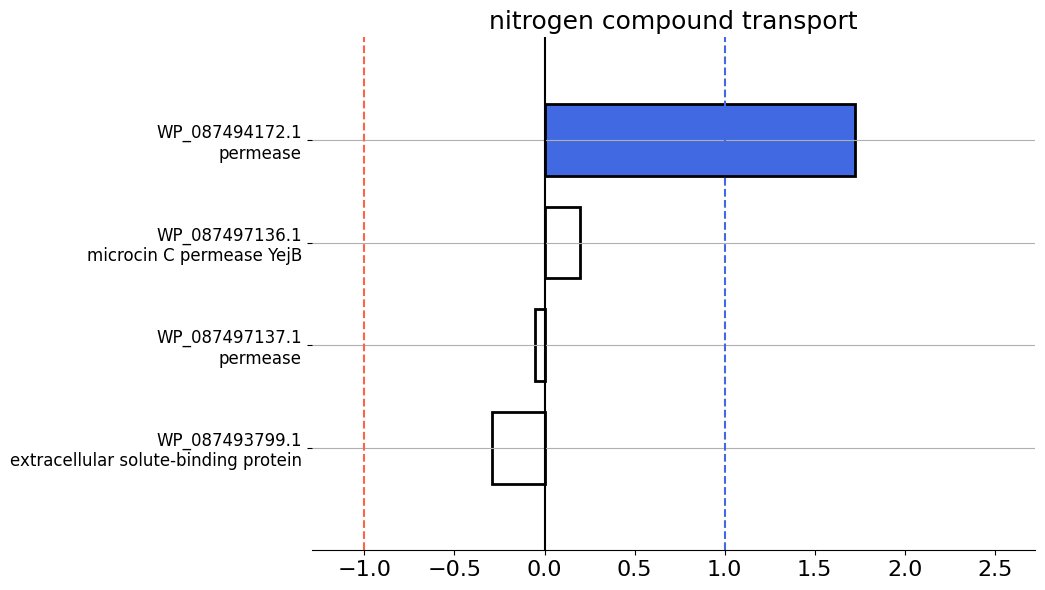

In [58]:
output_dir_tag = "mouth_opening"
transporter_dict = {}
for key in list(compressed_counts.keys())[:]:
    print(go_dag[key])
    transporter = table[table["qpid"].isin(compressed_counts[key][1])]
    transporter = transporter.rename(columns={"gene_id":"old_locus_tag"})
    print(len(table[table["qpid"].isin(compressed_counts[key][1])].qpid.unique()))
    transporter = transporter.drop_duplicates(subset="qpid")
    
    
    transporter= transporter.merge(deseq_table, on="old_locus_tag")
    transporter_dict[key] = transporter
    if(len(transporter)) > 1:
        transporter = transporter.sort_values(by="log2FoldChange")

        protein_dict = get_protein_info_batch(transporter.protein_id.to_list())
        yticklabels = []
        for protein in protein_dict:
            desc = protein_dict[protein].replace("[Curvibacter sp. AEP1-3]","")
            desc = desc.replace("MULTISPECIES:","")
            desc = desc.replace("[Comamonadaceae]","")
            desc = desc.replace("ABC transporter","")
            desc = desc.replace("sn-glycerol-3-phosphate","")
            desc = desc.replace("ABCB family","")
            desc = desc.replace("  "," ")
            desc = desc.replace("branched-chain amino acid","BCAA")
            desc = desc.strip()
            yticklabels.append(protein + "\n" + desc)
        colors = []
        for val, pval in zip(transporter.log2FoldChange,transporter.padj):
            if val < 0.0 and pval <= 0.05:
                colors.append("tomato")
            elif val > 0.0 and pval <= 0.05:
                colors.append("royalblue")
            else:
                colors.append("white")

        length = int(len(transporter))
        width, height = calculate_figsize(len(transporter))

        
        plt.figure(figsize=(width,height+2))
        plt.barh(y=transporter["protein_id"],width=transporter["log2FoldChange"], color=colors,edgecolor="black",lw=2, height=0.7)
        ax = plt.gca()  # Get current axis
        ax.spines['top'].set_visible(False)   # Remove upper x-axis line
        ax.spines['left'].set_visible(False)  # Remove left y-axis line
        ax.spines['right'].set_visible(False) # Remove right y-axis line
        plt.vlines(x=-1, ymin=-1,ymax=len(transporter),colors="tomato",linestyles="--")
        plt.vlines(x=1, ymin=-1,ymax=len(transporter),colors="royalblue", linestyles="--")
        plt.vlines(x=0, ymin=-1,ymax=len(transporter),colors="black")

        plt.xlim(min(transporter.log2FoldChange)-1, max(transporter.log2FoldChange)+1)
        plt.ylim(-1,len(transporter))
        plt.xticks(fontsize=16)
        plt.yticks(ticks=ax.get_yticks(),fontsize=12, labels=yticklabels, ha="right")
        plt.title(go_dag[key].name,fontsize=18)
        plt.grid(axis="y")
        plt.tight_layout()
        plt.savefig("../results/figures/transcriptomics/{}/{}".format(output_dir_tag,go_dag[key].name.replace(" ","_") + ".svg"), bbox_inches="tight")
        plt.show()
        plt.close()
    

# Gene Ontology Transporter Pie Chart

In [59]:
for go_id in compressed_counts.keys():
    print(go_dag[go_id])

GO:0043190	level-04	depth-05	ATP-binding cassette (ABC) transporter complex [cellular_component]
GO:0015833	level-06	depth-06	peptide transport [biological_process]
GO:0015417	level-04	depth-07	ABC-type polyamine transporter activity [molecular_function]
GO:0006865	level-04	depth-04	amino acid transport [biological_process]
GO:0015803	level-05	depth-06	branched-chain amino acid transport [biological_process]
GO:0030001	level-06	depth-06	metal ion transport [biological_process]
GO:0008643	level-04	depth-04	carbohydrate transport [biological_process]
GO:0022803	level-03	depth-03	passive transmembrane transporter activity [molecular_function]
GO:0015849	level-04	depth-04	organic acid transport [biological_process]
GO:0006833	level-05	depth-05	water transport [biological_process]
GO:0015698	level-04	depth-04	inorganic anion transport [biological_process]
GO:0051180	level-04	depth-04	vitamin transport [biological_process]
GO:0033036	level-02	depth-02	macromolecule localization [biological_p

In [60]:
count_dict = {}
for go_id in compressed_counts.keys():
    count_dict[go_id] = compressed_counts[go_id][0]
    if compressed_counts[go_id][0] == 1 or compressed_counts[go_id][0] == 2:
        print(go_dag[go_id])

GO:0022803	level-03	depth-03	passive transmembrane transporter activity [molecular_function]
GO:0015849	level-04	depth-04	organic acid transport [biological_process]
GO:0006833	level-05	depth-05	water transport [biological_process]


/tmp/ipykernel_53/3480673641.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap("tab20c", len(categories)).colors


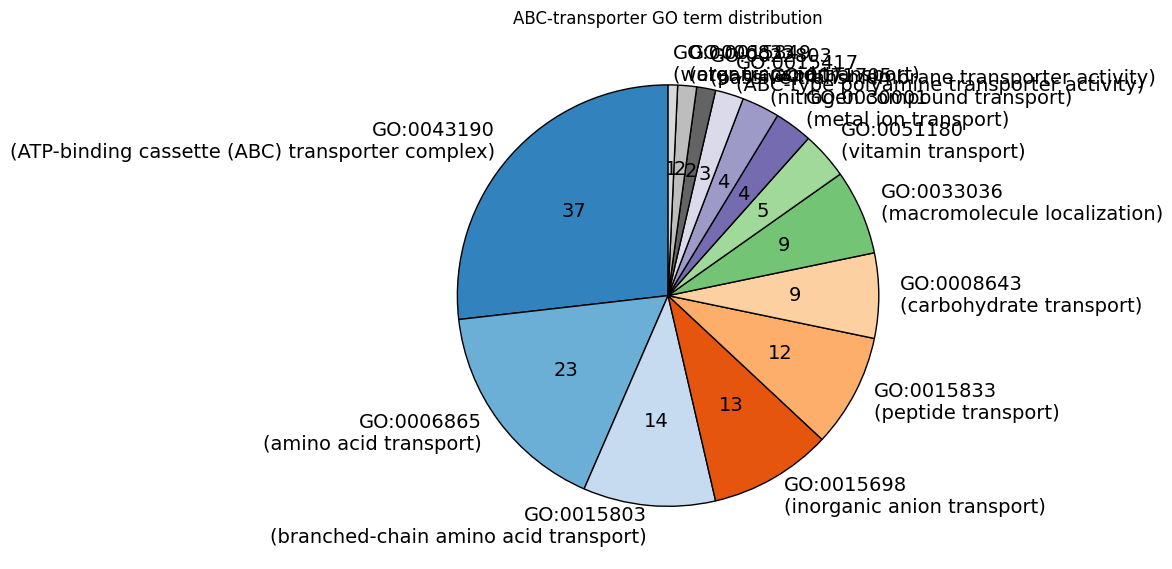

In [61]:
#counts = corrected_counts
#sorted_go_counts = sorted(enriched_counts.items(), key=lambda x: x[1], reverse=True)

sorted_go_counts = sorted(count_dict.items(), key=lambda x:x[1], reverse=True)
top_10 = sorted_go_counts[:]
#others = sorted_go_counts[:]
others = []
others_total = sum(count for _, count in others)

categories = [f"{name}\n({go_dag[name].name})" for name, _ in top_10] #+ ["Others"]
counts = [count for _, count in top_10] #+ [others_total]

colors = cm.get_cmap("tab20c", len(categories)).colors

def count_formatter(pct, all_values):
    total = sum(all_values)
    value = int(round(pct * total / 100.0))  # Calculate actual value from percentage
    return f"{value}"  # Display as total count

plt.figure(figsize=(10, 8))
plt.pie(
    counts,
    labels=categories,
    autopct=lambda p: '{:.0f}'.format(p * sum(counts) / 100), #count_formatter(pct, counts) + f" - {pct:.2f}"
    #autopct=lambda pct: f"{pct:.1f}%" if pct > 2 else "",  # Show % only for >5%
    colors=colors,
    startangle=90,
    radius=1.0,
    wedgeprops={"edgecolor": "k"},
    textprops={"fontsize":14}# Add a border to slices
)
plt.title("ABC-transporter GO term distribution")
plt.tight_layout()
#plt.show()
plt.savefig("../results/figures/corrected_abc_transporters.svg")

In [22]:
samples = pd.read_csv("../data/transcriptomics_data/mono_culture.csv")

In [23]:
samples 

,ID,sample,treatment,batch,replicate
0,SRR21836205,sra_1_1,plate_mono_culture_kiel,2,sra_1
1,SRR21836206,sra_1_2,plate_mono_culture_kiel,2,sra_2
2,SRR21836207,sra_1_3,plate_mono_culture_kiel,2,sra_3
3,SRR21836208,sra_1_4,plate_mono_culture_kiel,2,sra_4
4,SRR21836209,sra_1_5,plate_mono_culture_kiel,2,sra_5
5,SRR21836210,sra_2_1,liquid_mono_culture_kiel,2,sra_6
6,SRR21836211,sra_2_2,liquid_mono_culture_kiel,2,sra_7
7,SRR21836212,sra_2_3,liquid_mono_culture_kiel,2,sra_8
8,SRR21836213,sra_3_1,hydra_mono_culture_kiel,2,sra_9
9,SRR21836214,sra_3_2,hydra_mono_culture_kiel,2,sra_10


In [24]:
samples = samples[(samples["treatment"] == "liquid_mono_culture_kiel") | (samples["treatment"] == "hydra_mono_culture_kiel")]

In [25]:
liquid_samples = samples[(samples["treatment"] == "liquid_mono_culture_kiel") ]
liquid_tables = []
for sample in liquid_samples.ID:
    print("[+] Working with sample: {}".format(sample))
    temp_df = pd.read_table("../data/transcriptomics_data/count_data/{}.genes.results".format(sample))
    temp_df = temp_df.rename(columns={"TPM":"{}".format(sample)})
    liquid_tables.append(temp_df[["gene_id","{}".format(sample)]])

liquid_df = liquid_tables[0]
for tab in liquid_tables[1:]:
    liquid_df = liquid_df.merge(tab, on="gene_id")

[+] Working with sample: SRR21836210
[+] Working with sample: SRR21836211
[+] Working with sample: SRR21836212
[+] Working with sample: SRR21836218
[+] Working with sample: SRR21836219


In [26]:
hydra_samples = samples[(samples["treatment"] == "hydra_mono_culture_kiel") ]
hydra_tables = []
for sample in hydra_samples.ID:
    print("[+] Working with sample: {}".format(sample))
    temp_df = pd.read_table("../data/transcriptomics_data/count_data/{}.genes.results".format(sample))
    temp_df = temp_df.rename(columns={"TPM":"{}".format(sample)})
    hydra_tables.append(temp_df[["gene_id","{}".format(sample)]])

hydra_df = hydra_tables[0]
for tab in hydra_tables[1:]:
    hydra_df = hydra_df.merge(tab, on="gene_id")

[+] Working with sample: SRR21836213
[+] Working with sample: SRR21836214
[+] Working with sample: SRR21836215
[+] Working with sample: SRR21836216
[+] Working with sample: SRR21836217


In [27]:
tpm_df = pd.merge(liquid_df, hydra_df, on="gene_id")
tpm_df["gene_id"] = tpm_df["gene_id"].apply(lambda x: x.split(":")[-1])
tpm_df.head()

,gene_id,SRR21836210,SRR21836211,SRR21836212,SRR21836218,SRR21836219,SRR21836213,SRR21836214,SRR21836215,SRR21836216,SRR21836217
0,AEP_00001,511.68,570.89,638.69,962.26,867.05,0.00,492.51,295.43,0.00,564.89
1,AEP_00002,5.99,9.25,7.93,14.19,11.97,28.19,30.87,0.00,0.00,8.57
2,AEP_00003,406.26,204.64,167.14,308.27,294.10,161.53,356.59,214.15,349.98,100.21
3,AEP_00004,10.35,6.90,8.86,16.71,13.92,59.19,0.00,58.52,0.00,0.00
4,AEP_00005,66.73,66.72,74.31,172.67,137.28,0.00,183.47,110.19,359.58,51.58


In [28]:
transporter_dict["GO:0006865"] = transporter_dict["GO:0006865"][transporter_dict["GO:0006865"]["padj"] <= 0.05]
amino_acid_transporter = list(transporter_dict["GO:0006865"].old_locus_tag.unique())

transporter_dict["GO:0015803"] = transporter_dict["GO:0015803"][transporter_dict["GO:0015803"]["padj"] <= 0.05]
amino_acid_transporter = amino_acid_transporter + list(transporter_dict["GO:0015803"].old_locus_tag.unique())

len(amino_acid_transporter)

27

In [29]:
samples["col_name"] = samples["treatment"].apply(lambda x: x.split("_")[0])

/tmp/ipykernel_24/3664421951.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples["col_name"] = samples["treatment"].apply(lambda x: x.split("_")[0])


In [30]:
import seaborn as sns

In [31]:
aa_tpm_df = tpm_df[tpm_df["gene_id"].isin(amino_acid_transporter)]
aa_tpm_df = aa_tpm_df.rename(columns={"gene_id":"Locus Tag"})
aa_tpm_df.index = aa_tpm_df["Locus Tag"]
aa_tpm_df = aa_tpm_df.iloc[:,1:]
aa_tpm_df.head()

,SRR21836210,SRR21836211,SRR21836212,SRR21836218,SRR21836219,SRR21836213,SRR21836214,SRR21836215,SRR21836216,SRR21836217
Locus Tag,,,,,,,,,,
AEP_00267,89.15,76.45,77.24,101.82,101.65,0.00,0.0,90.10,201.3,27.96
AEP_00980,15.41,13.09,10.32,19.80,20.02,17.50,0.0,34.51,0.0,16.02
AEP_00981,7.29,6.07,4.22,4.01,7.54,0.00,0.0,0.00,0.0,0.00
AEP_00982,6.29,7.32,8.96,10.35,8.93,0.00,0.0,22.09,0.0,0.00
AEP_01233,33.35,28.11,23.77,39.03,34.07,18.22,0.0,0.00,0.0,33.36


In [32]:
new_cols = []
for col in aa_tpm_df.columns:
    new_cols.append(samples[samples.ID == col]["col_name"].values[0])
aa_tpm_df.columns = new_cols

In [33]:
aa_tpm_df

,liquid,liquid,liquid,liquid,liquid,hydra,hydra,hydra,hydra,hydra
Locus Tag,,,,,,,,,,
AEP_00267,89.15,76.45,77.24,101.82,101.65,0.00,0.00,90.10,201.30,27.96
AEP_00980,15.41,13.09,10.32,19.80,20.02,17.50,0.00,34.51,0.00,16.02
AEP_00981,7.29,6.07,4.22,4.01,7.54,0.00,0.00,0.00,0.00,0.00
AEP_00982,6.29,7.32,8.96,10.35,8.93,0.00,0.00,22.09,0.00,0.00
AEP_01233,33.35,28.11,23.77,39.03,34.07,18.22,0.00,0.00,0.00,33.36
AEP_01235,1906.86,1005.65,1117.74,1888.24,1811.74,429.84,553.57,1013.63,500.40,616.12
AEP_01292,10.39,9.73,9.36,14.86,8.50,17.34,0.00,17.10,0.00,0.00
AEP_01490,6.24,4.17,5.79,30.00,8.41,0.00,0.00,0.00,0.00,0.00
AEP_01493,1.79,2.37,1.11,21.47,5.06,0.00,0.00,0.00,0.00,0.00


<Figure size 1000x800 with 0 Axes>

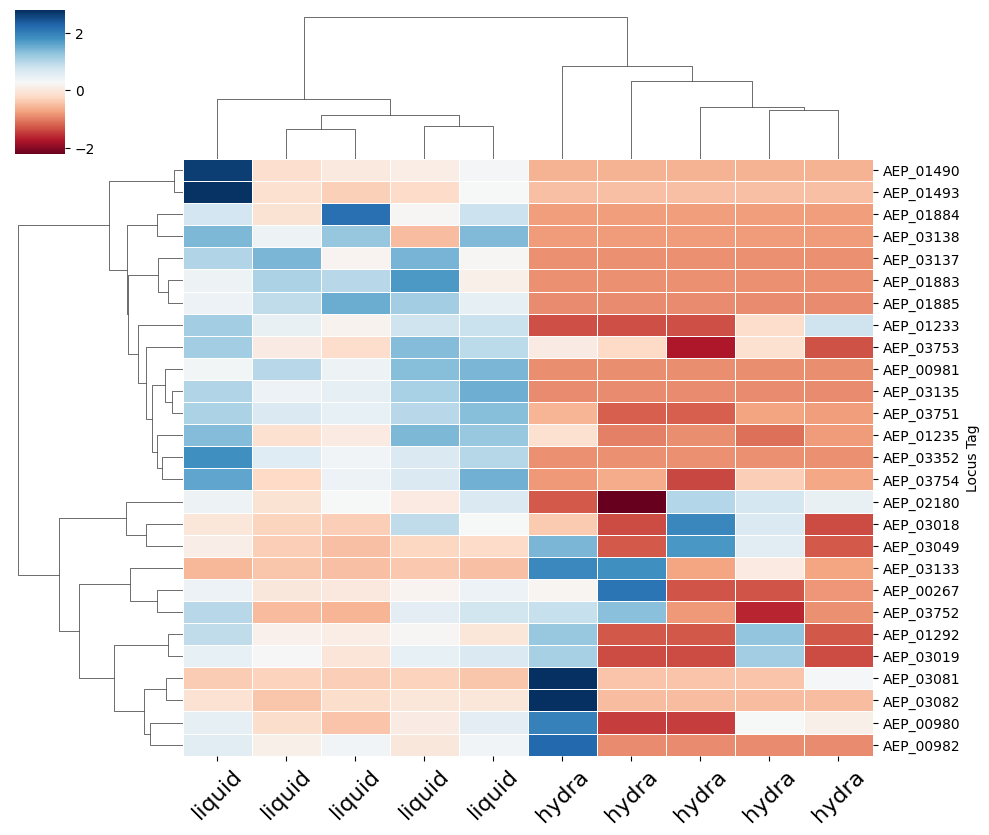

In [34]:
# Set figure size
plt.figure(figsize=(10, 8))

# Create clustermap
g = sns.clustermap(
    aa_tpm_df, 
    cmap="RdBu",        # Color map (can be changed, e.g., "coolwarm", "magma", "RdBu_r")
    method="ward",         # Clustering method (alternatives: "average", "single", "complete")
    metric="euclidean",    # Distance metric (alternatives: "correlation", "cosine")
    figsize=(10, 8),       # Figure size
    z_score=0,             # Standardize rows (0 for genes, 1 for samples, None for no scaling)
    linewidths=0.5,        # Add space between heatmap cells
    xticklabels=True,      # Show sample names
    yticklabels=True,       # Show gene names
)

g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize=16, rotation=45)  # Rotate if needed

# Adjust yticklabel fontsize
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize=10)

#plt.title("Gene Expression Heatmap with Clustering")
plt.savefig("../results/figures/transcriptomics/aa_transporter_heatmap_tpm_vals.svg")

In [94]:
# mouth opening
raw_counts = pd.read_csv("../data/transcriptomics_data/mouth_opening_raw_counts.csv", sep=";")
raw_counts = raw_counts.rename(columns={"Unnamed: 0":"locus_tag"})
raw_counts.head()

,locus_tag,Hydra,Hydra.1,Hydra.2,Hydra.3,Hydra.4,Liquid,Liquid.1,Liquid.2,Liquid.3,Liquid.4
0,AEP_RS00005,1,8,5,10,10,2096,846,782,1353,1672
1,AEP_RS00010,5,13,12,29,22,477,176,169,407,503
2,AEP_RS00015,7,23,11,28,23,2227,1243,2244,1843,2073
3,AEP_RS00020,1,9,1,12,9,143,62,74,124,188
4,AEP_RS00025,4,6,4,10,4,614,255,249,616,893


In [95]:
locus_tag_to_length = pd.read_csv("../data/transcriptomics_data/gene_length_mouth_opening.csv", sep=";")
locus_tag_to_length = locus_tag_to_length.rename(columns={"GeneID":"locus_tag"})

merged_counts = raw_counts.merge(locus_tag_to_length, on="locus_tag")
merged_counts.iloc[:,1:-1] = merged_counts.iloc[:,1:-1].div((merged_counts["Length_bp"]/1000), axis=0)

cols_to_keep = ["locus_tag"]
for col in merged_counts.iloc[:,1:-1].columns:
    summation = sum(merged_counts[col])
    merged_counts[col+"_tpm"] = merged_counts[col].apply(lambda x: (x/summation)*10**6)
    cols_to_keep.append(col+"_tpm")

tpm_table = merged_counts[cols_to_keep]

In [97]:
tpm_table.to_csv("../results/processed_data/tpm_table_mouth_opening.csv")

In [66]:
amino_acid_transporter_locus_tag = translation_table[translation_table["old_locus_tag"].isin(amino_acid_transporter)]["locus_tag"]

In [78]:
tpm_heatmap_table = tpm_table[tpm_table["locus_tag"].isin(amino_acid_transporter_locus_tag)].iloc[:,:]
tpm_heatmap_table.index = tpm_heatmap_table["locus_tag"]

In [80]:
tpm_heatmap_table = tpm_heatmap_table.iloc[:,1:]

<Figure size 1000x800 with 0 Axes>

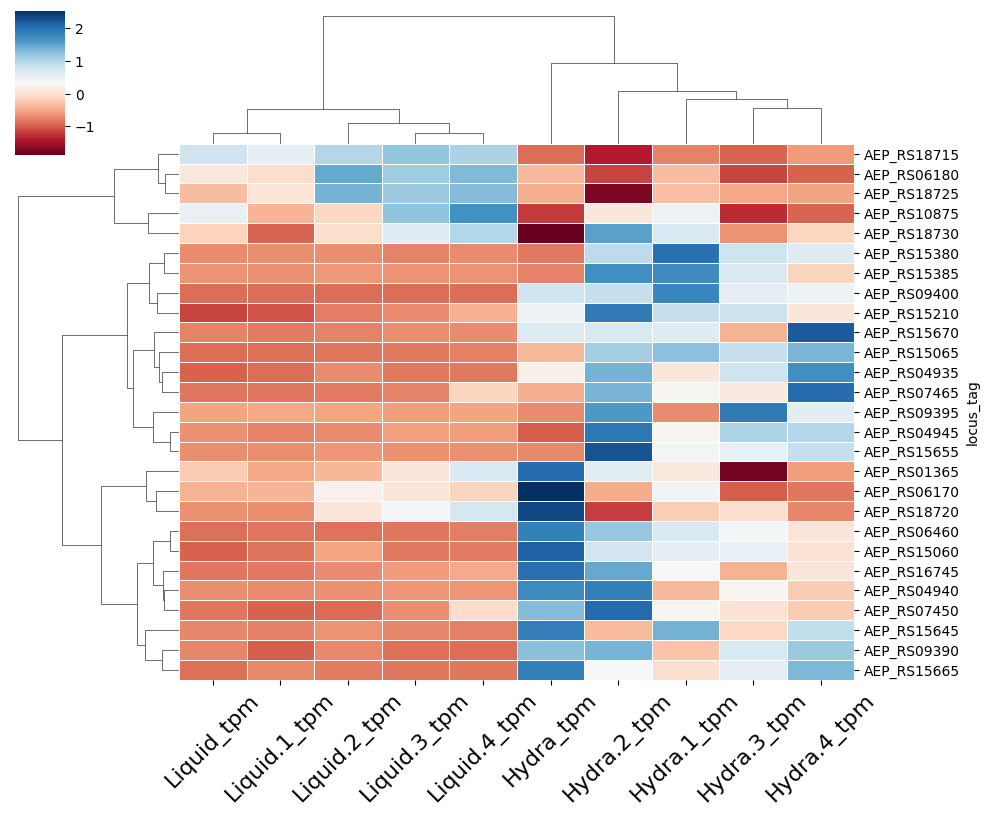

In [81]:
# Set figure size
plt.figure(figsize=(10, 8))

# Create clustermap
g = sns.clustermap(
    tpm_heatmap_table, 
    cmap="RdBu",        # Color map (can be changed, e.g., "coolwarm", "magma", "RdBu_r")
    method="ward",         # Clustering method (alternatives: "average", "single", "complete")
    metric="euclidean",    # Distance metric (alternatives: "correlation", "cosine")
    figsize=(10, 8),       # Figure size
    z_score=0,             # Standardize rows (0 for genes, 1 for samples, None for no scaling)
    linewidths=0.5,        # Add space between heatmap cells
    xticklabels=True,      # Show sample names
    yticklabels=True,       # Show gene names
)

g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize=16, rotation=45)  # Rotate if needed

# Adjust yticklabel fontsize
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize=10)

#plt.title("Gene Expression Heatmap with Clustering")
plt.savefig("../results/figures/transcriptomics/aa_transporter_heatmap_tpm_vals.svg")

In [85]:
tpm_heatmap_table.loc["AEP_RS15665"]

Hydra_tpm       72.277257
Hydra.1_tpm     28.657433
Hydra.2_tpm     37.683921
Hydra.3_tpm     42.334347
Hydra.4_tpm     60.357708
Liquid_tpm       9.549312
Liquid.1_tpm    12.815383
Liquid.2_tpm    11.050880
Liquid.3_tpm    10.069196
Liquid.4_tpm    10.076944
Name: AEP_RS15665, dtype: float64

In [1]:
# other mono colonization

In [75]:
cds_table = pd.read_csv("../data/transcriptomics_data/cds_table_with_length.csv", index_col=0)
cds_table.head()

,seqname,source,feature,start,end,score,strand,frame,attribute,locus_tag,length_bp
2,NZ_CP015698.1,Protein Homology,CDS,108.0,431.0,.,-,0,ID=cds-WP_087493495.1;Parent=gene-AEP_RS00005;...,AEP_RS00005,323.0
4,NZ_CP015698.1,Protein Homology,CDS,563.0,2617.0,.,-,0,ID=cds-WP_087493496.1;Parent=gene-AEP_RS00010;...,AEP_RS00010,2054.0
6,NZ_CP015698.1,Protein Homology,CDS,2846.0,3376.0,.,+,0,ID=cds-WP_087493497.1;Parent=gene-AEP_RS00015;...,AEP_RS00015,530.0
8,NZ_CP015698.1,Protein Homology,CDS,3516.0,4310.0,.,-,0,ID=cds-WP_087493498.1;Parent=gene-AEP_RS00020;...,AEP_RS00020,794.0
10,NZ_CP015698.1,Protein Homology,CDS,4544.0,5065.0,.,+,0,ID=cds-WP_087493499.1;Parent=gene-AEP_RS00025;...,AEP_RS00025,521.0


In [76]:
cds_table = cds_table.rename(columns={"locus_tag":"Geneid"})
cds_table = cds_table[["Geneid","length_bp"]]
cds_table.head()

,Geneid,length_bp
2,AEP_RS00005,323.0
4,AEP_RS00010,2054.0
6,AEP_RS00015,530.0
8,AEP_RS00020,794.0
10,AEP_RS00025,521.0


In [84]:
feature_counts = pd.read_csv("../data/transcriptomics_data/featureCounts/PRJNA887579/featureCounts_table.csv", index_col=0)
feature_counts = feature_counts.merge(cds_table, on="Geneid")
rpk_table = feature_counts.loc[:,~feature_counts.columns.isin(["Geneid","length_bp"])].div(feature_counts["length_bp"]/1000, axis=0)
tpm_table = rpk_table.div(rpk_table.sum(axis=0)*10**6, axis=1)

In [85]:
tpm_table["locus_tag"] = feature_counts["Geneid"]
tpm_table.head()

,SRR21836205,SRR21836206,SRR21836207,SRR21836208,SRR21836209,SRR21836210,SRR21836211,SRR21836212,SRR21836213,SRR21836214,SRR21836215,SRR21836216,SRR21836217,SRR21836218,SRR21836219,locus_tag
0,1.045955e-09,7.653982e-10,8.740646e-10,8.510921e-10,6.551866e-10,4.013590e-10,4.164005e-10,4.854152e-10,1.336109e-10,4.233485e-10,1.899316e-10,0.000000e+00,2.514941e-10,6.025047e-10,5.435117e-10,AEP_RS00005
1,6.429180e-11,6.087656e-11,5.401272e-11,4.618465e-11,4.654804e-11,1.686170e-11,1.618014e-11,2.071997e-11,4.202173e-11,3.328665e-11,0.000000e+00,0.000000e+00,9.887123e-12,3.033412e-11,2.652500e-11,AEP_RS00010
2,4.513528e-10,3.085770e-10,2.265081e-10,2.441933e-10,2.227907e-10,4.574294e-10,2.541895e-10,2.329853e-10,2.849945e-10,2.580029e-10,2.315015e-10,5.262454e-10,2.299036e-10,3.337255e-10,2.988210e-10,AEP_RS00015
3,3.792137e-11,3.273014e-11,2.398275e-11,1.978429e-11,2.454507e-11,1.520682e-11,8.146554e-12,1.134156e-11,8.152956e-11,0.000000e+00,5.150958e-11,0.000000e+00,0.000000e+00,2.194036e-11,1.483623e-11,AEP_RS00020
4,3.708692e-10,3.987827e-10,2.812725e-10,2.845930e-10,2.759279e-10,8.355226e-11,7.920096e-11,9.565639e-11,2.070840e-11,1.312299e-10,7.850020e-11,2.676680e-10,3.897917e-11,2.036340e-10,1.560739e-10,AEP_RS00025


In [86]:
experiments = pd.read_csv("../data/transcriptomics_data/mono_culture.csv")

new_cols = []
for col in tpm_table.columns:
    if col != "locus_tag":
        treatment = experiments[experiments["ID"] == col]["treatment"].values[0]
        new_cols.append(treatment.split("_")[0])
    else:
        new_cols.append(col)

tpm_table.columns = new_cols
tpm_table.head()

,plate,plate,plate,plate,plate,liquid,liquid,liquid,hydra,hydra,hydra,hydra,hydra,liquid,liquid,locus_tag
0,1.045955e-09,7.653982e-10,8.740646e-10,8.510921e-10,6.551866e-10,4.013590e-10,4.164005e-10,4.854152e-10,1.336109e-10,4.233485e-10,1.899316e-10,0.000000e+00,2.514941e-10,6.025047e-10,5.435117e-10,AEP_RS00005
1,6.429180e-11,6.087656e-11,5.401272e-11,4.618465e-11,4.654804e-11,1.686170e-11,1.618014e-11,2.071997e-11,4.202173e-11,3.328665e-11,0.000000e+00,0.000000e+00,9.887123e-12,3.033412e-11,2.652500e-11,AEP_RS00010
2,4.513528e-10,3.085770e-10,2.265081e-10,2.441933e-10,2.227907e-10,4.574294e-10,2.541895e-10,2.329853e-10,2.849945e-10,2.580029e-10,2.315015e-10,5.262454e-10,2.299036e-10,3.337255e-10,2.988210e-10,AEP_RS00015
3,3.792137e-11,3.273014e-11,2.398275e-11,1.978429e-11,2.454507e-11,1.520682e-11,8.146554e-12,1.134156e-11,8.152956e-11,0.000000e+00,5.150958e-11,0.000000e+00,0.000000e+00,2.194036e-11,1.483623e-11,AEP_RS00020
4,3.708692e-10,3.987827e-10,2.812725e-10,2.845930e-10,2.759279e-10,8.355226e-11,7.920096e-11,9.565639e-11,2.070840e-11,1.312299e-10,7.850020e-11,2.676680e-10,3.897917e-11,2.036340e-10,1.560739e-10,AEP_RS00025


In [92]:
tpm_table.to_csv("../results/processed_data/tpm_table_virus.csv")

In [87]:
aa_tpm_table = tpm_table[tpm_table["locus_tag"].isin(amino_acid_transporter.merge(translation_table, on="old_locus_tag")["locus_tag"])]

In [88]:
aa_tpm_table.index = aa_tpm_table["locus_tag"]
aa_tpm_table = aa_tpm_table.loc[:,~aa_tpm_table.columns.isin(["locus_tag"])]
aa_tpm_table.head()

,plate,plate,plate,plate,plate,liquid,liquid,liquid,hydra,hydra,hydra,hydra,hydra,liquid,liquid
locus_tag,,,,,,,,,,,,,,,
AEP_RS01365,2.203444e-10,2.317760e-10,2.040589e-10,1.516875e-10,1.921947e-10,8.647165e-11,7.186753e-11,8.076126e-11,0.000000e+00,0.0,7.875213e-11,1.790180e-10,2.606951e-11,9.509240e-11,9.472198e-11
AEP_RS01375,1.143852e-10,1.146885e-10,1.196023e-10,1.042842e-10,1.199458e-10,8.021551e-11,6.569408e-11,7.751020e-11,4.539584e-11,0.0,1.434032e-11,0.000000e+00,1.424134e-11,7.880155e-11,9.109880e-11
AEP_RS04935,4.963127e-11,4.493772e-11,4.626444e-11,4.039637e-11,4.551175e-11,2.252553e-11,2.009098e-11,1.605003e-11,1.799679e-11,0.0,6.822119e-11,1.163095e-10,1.693757e-11,2.473910e-11,2.428916e-11
AEP_RS04940,1.652809e-11,1.881535e-11,1.466612e-11,1.545938e-11,1.703221e-11,8.352090e-12,7.647327e-12,6.485152e-12,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,6.098347e-12,9.723149e-12
AEP_RS06170,6.294969e-11,6.462918e-11,8.207890e-11,6.432454e-11,6.957456e-11,4.848313e-11,3.595672e-11,3.105240e-11,1.860186e-11,0.0,0.000000e+00,6.010993e-11,3.501405e-11,4.694753e-11,4.428772e-11


<Figure size 1000x800 with 0 Axes>

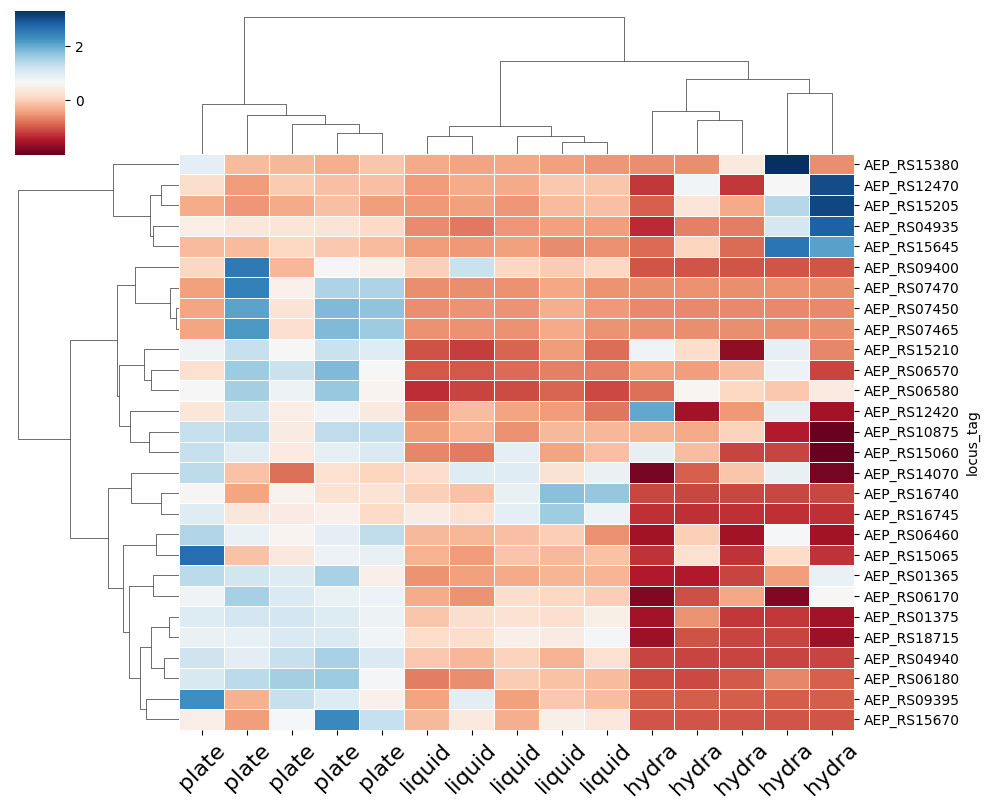

In [89]:
# Set figure size
plt.figure(figsize=(10, 8))

# Create clustermap
g = sns.clustermap(
    aa_tpm_table, 
    cmap="RdBu",        # Color map (can be changed, e.g., "coolwarm", "magma", "RdBu_r")
    method="ward",         # Clustering method (alternatives: "average", "single", "complete")
    metric="euclidean",    # Distance metric (alternatives: "correlation", "cosine")
    figsize=(10, 8),       # Figure size
    z_score=0,             # Standardize rows (0 for genes, 1 for samples, None for no scaling)
    linewidths=0.5,        # Add space between heatmap cells
    xticklabels=True,      # Show sample names
    yticklabels=True,       # Show gene names
)

g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize=16, rotation=45)  # Rotate if needed

# Adjust yticklabel fontsize
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize=10)

#plt.title("Gene Expression Heatmap with Clustering")
plt.savefig("../results/figures/transcriptomics/aa_transporter_heatmap_tpm_vals_virus_plate_liquid_hydra.svg")

In [90]:
feature_counts

,Geneid,SRR21836205,SRR21836206,SRR21836207,SRR21836208,SRR21836209,SRR21836210,SRR21836211,SRR21836212,SRR21836213,SRR21836214,SRR21836215,SRR21836216,SRR21836217,SRR21836218,SRR21836219,length_bp
0,AEP_RS00005,1425,1817,682,3150,923,408,603,1271,4,4,6,0,8,1240,1073,323.0
1,AEP_RS00010,557,919,268,1087,417,109,149,345,8,2,0,0,2,397,333,2054.0
2,AEP_RS00015,1009,1202,290,1483,515,763,604,1001,14,4,12,4,12,1127,968,530.0
3,AEP_RS00020,127,191,46,180,85,38,29,73,6,0,4,0,0,111,72,794.0
4,AEP_RS00025,815,1527,354,1699,627,137,185,404,1,2,4,2,2,676,497,521.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4033,AEP_RS20535,66,93,33,200,65,57,50,82,2,0,0,0,4,110,62,206.0
4034,AEP_RS20540,1069,1034,324,1430,455,421,386,569,7,0,4,0,5,683,888,311.0
4035,AEP_RS20545,682,958,380,1683,706,817,700,1096,6,8,16,2,8,1170,1378,575.0
4036,AEP_RS20550,2476,3624,1280,6228,2457,2011,2076,3563,24,24,48,2,35,3808,4103,695.0
